## Check the self-consistency of the Non linear Step in the schrodinger equation

Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.training.models_adiabatic import Energy_XXZX, Energy_reduction_XXZX
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver

from src.tddft_methods.kohm_sham_utils import nonlinear_master_equation_step
from src.gradient_descent import GradientDescentKohmSham
from typing import List
import os
from src.tddft_methods.kohm_sham_utils import (
    nonlinear_schrodinger_step,
    initialize_psi_from_z_and_x
)

Initialization and Data

In [2]:
data = np.load(
    "data/kohm_sham_approach/disorder/2_input_channel_dataset_h_mixed_0.0_5.0_h_0.0-2.0_j_1_1nn_n_6000.npz"
)


z = data["density"]

print(z.shape)

l = z.shape[-1]

model = torch.load(
    "model_rep/kohm_sham/disorder/model_zzxz_2_input_channel_dataset_h_mixed_0.0_5.0_h_0.0-2.0_j_1_1nn_n_500k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock",
    map_location="cpu",
)
model.eval()
model = model.to(dtype=torch.double)
energy = Energy_XXZX(model=model)
energy.eval()
# Implement the Kohm Sham LOOP
z_target = torch.from_numpy(z).double()

# initialization
exponent_algorithm = True
self_consistent_step = 30
eta = 0.1
steps = 1000
tf = 10.0
time = torch.linspace(0.0, tf, steps)
dt = time[1] - time[0]

ndata = 10
rates = np.linspace(0.0, 0.2, ndata)

rates

hi = torch.ones((2, l))
hi[1] = 2.0  # high transverse field
hi[0] = 0.5
# define the final external field
hf = torch.ones((2, l))
hf[1] = 1.0
hf[0] = 0.5


# define the delta for the periodic driving
delta = torch.ones((2, l))
delta[1] = 0.9
delta[0] = 0.0

gd = GradientDescentKohmSham(
    loglr=-3,
    energy=energy,
    epochs=5000,
    seed=23,
    num_threads=3,
    device="cpu",
    n_init=torch.mean(z_target, dim=0),
    h=hi,
)

rate=0.1

zi = gd.run()
zi = torch.from_numpy(zi)[0]

psi0 = initialize_psi_from_z_and_x(z=-1 * zi[0], x=zi[1])



/home/ecosta/tddft_project/src/gradient_descent.py:482: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_init = pt.tensor(self.n_init, dtype=pt.double).unsqueeze(0)
/home/ecosta/tddft_project/src/gradient_descent.py:513: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pot = pt.tensor(self.h, device=self.device).unsqueeze(0)


(6000, 2, 8)
loading the model...
starting the cycle...
torch.Size([1, 2, 8])
is leaf=True


eng=-16.978855 , :   0%|          | 0/5000 [00:00<?, ?it/s]

eng=-17.219415 , :  55%|█████▌    | 2766/5000 [00:25<00:21, 105.11it/s]

Time hyperameters

torch.Size([2, 8])


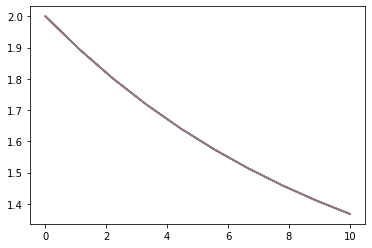

In [34]:
print(hi.shape)
steps = 10
tf = 10.0
time = torch.linspace(0.0, tf, steps)

h=hi[None,:,:]*torch.exp(-rate*time[:,None,None])+(1-torch.exp(-rate*time[:,None,None]))*hf[None,:,:]


plt.plot(time,h[:,1].detach().numpy())
plt.show()

Test the step

In [35]:
x_self_consistency:List=[]
y_self_consistency:List=[]
z_self_consistency:List=[]

scs=np.arange(10)

for self_consistent_step in (scs):
    psi,_,_,_,x,y,z=nonlinear_schrodinger_step(psi=psi0,energy=energy,i=0,h=h,self_consistent_step=self_consistent_step,dt=dt,eta=None,exponent_algorithm=True)
    x_self_consistency.append(x[0].detach().numpy())
    y_self_consistency.append(y[0].detach().numpy())
    z_self_consistency.append(z[0].detach().numpy())

Plots

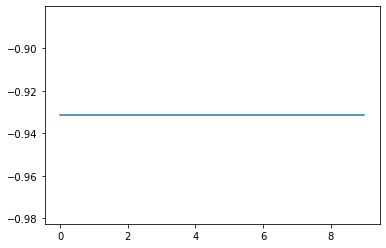

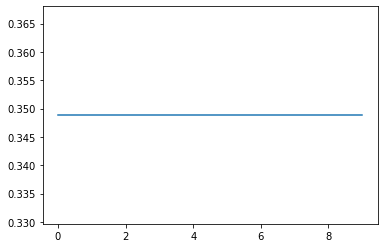

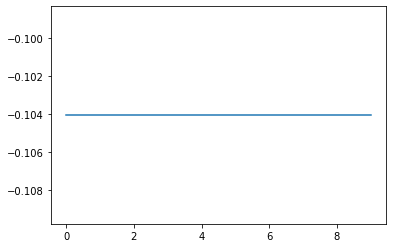

In [36]:
plt.plot(scs,x_self_consistency)
plt.show()

plt.plot(scs,y_self_consistency)
plt.show()


plt.plot(scs,z_self_consistency)
plt.show()